<a href="https://colab.research.google.com/github/skrakibulislamrahat/Multimodal_Framework_Research/blob/main/DR_Multimodal_External_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q scikit-learn pandas seaborn tqdm

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import zipfile
import os

dataset_zip = "/content/drive/My Drive/Colab_Notebooks/DR_Project/External_Validation/Dataset.zip"
extract_path = "/content/DR_Data"

# Extract if not already
if not os.path.exists(extract_path):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extracted Dataset.zip")
else:
    print("✅ Already extracted. Skipping.")

✅ Extracted Dataset.zip


In [8]:
image_dir = f"{extract_path}/my_preprocessed"
label_path = f"{extract_path}/grades.csv"
model_path = "/content/drive/My Drive/Colab_Notebooks/DR_Project/final_fusion_model.keras"

In [9]:
from tensorflow.keras.models import load_model
model = load_model(model_path)
print("✅ Model loaded.")

✅ Model loaded.


In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

df = pd.read_csv(label_path)
df = df.dropna(subset=['adjudicated_dr_grade'])
df['label'] = df['adjudicated_dr_grade'].astype(int)
df['filename'] = df['image_id'].astype(str).str.strip()  # filenames already include .png

IMG_SIZE = 224
X, y = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(image_dir, row['filename'])
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img = np.array(img) / 255.0
        X.append(img)
        y.append(row['label'])

X = np.array(X)
y = np.array(y)
print(f"✅ Loaded {len(X)} images.")

100%|██████████| 1744/1744 [00:16<00:00, 103.99it/s]


✅ Loaded 1057 images.


In [11]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# ✅ Simulate 6 clinical metadata features
num_samples = len(X)
metadata = np.random.normal(loc=0, scale=1, size=(num_samples, 6)).astype(np.float32)

# 🔮 Predict using both inputs
y_probs = model.predict([X, metadata], verbose=1)
y_preds = np.argmax(y_probs, axis=1)

# 📊 Classification Report
print("📊 Classification Report:\n")
print(classification_report(y, y_preds, digits=4))

# 🎯 Macro AUC Score
y_bin = label_binarize(y, classes=[0,1,2,3,4])
auc_score = roc_auc_score(y_bin, y_probs, average='macro')
print("🎯 Macro AUC Score:", round(auc_score, 4))

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step
📊 Classification Report:

              precision    recall  f1-score   support

           0     0.5093    0.3504    0.4152       468
           1     0.0000    0.0000    0.0000       207
           2     0.2816    0.7138    0.4039       290
           3     0.0000    0.0000    0.0000        71
           4     0.0000    0.0000    0.0000        21

    accuracy                         0.3510      1057
   macro avg     0.1582    0.2128    0.1638      1057
weighted avg     0.3028    0.3510    0.2946      1057

🎯 Macro AUC Score: 0.5031


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


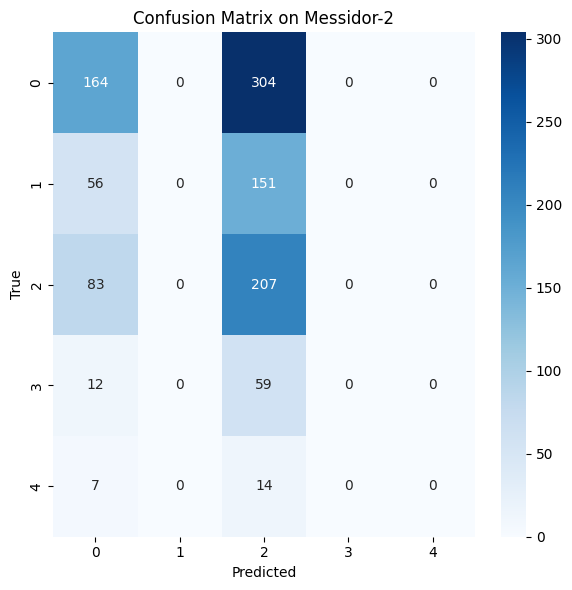

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y, y_preds)

# Plot and save
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix on Messidor-2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_messidor2.png")
plt.show()

In [13]:
from sklearn.metrics import precision_recall_fscore_support

class_labels = ['No DR (0)', 'Mild (1)', 'Moderate (2)', 'Severe (3)', 'Proliferative (4)']
precision, recall, f1, support = precision_recall_fscore_support(y, y_preds, labels=[0,1,2,3,4])

# Create Table 2
table2 = pd.DataFrame({
    'Class': class_labels,
    'Precision': np.round(precision, 2),
    'Recall': np.round(recall, 2),
    'F1-score': np.round(f1, 2),
    'Support': support
})

print(table2)

               Class  Precision  Recall  F1-score  Support
0          No DR (0)       0.51    0.35      0.42      468
1           Mild (1)       0.00    0.00      0.00      207
2       Moderate (2)       0.28    0.71      0.40      290
3         Severe (3)       0.00    0.00      0.00       71
4  Proliferative (4)       0.00    0.00      0.00       21


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
